In [35]:
# Standard libraries
import numpy as np
import json
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "mesoscopic-functional-connectivity"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
codepath = os.path.join(rootpath, "code_python")
sys.path.append(codepath)
print("Appended root directory", codepath)

# User libraries
from lib.info_metrics.projector_metrics import metric3D

from lib.stat import graph_lib
from lib.info_metrics.corr_lib import corr_3D, cross_corr_3D, corr_2D
from lib.data_io.qt_wrapper import gui_fnames, gui_fpath
from lib.data_io.data_fc_db import DataFCDatabase
import lib.plots.connectomics as connectomics
import lib.plots.connectomics_db as connectomics_db
import lib.plots.data_plots as data_plots
import lib.plots.data_plots_db as data_plots_db

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/mesoscopic-functional-connectivity/code_python
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reading Data
* Automatically find subfolders for FC, data and behaviour
* Parse filenames and folders to identify mice, dates and analysis types
* Read all datasets into memory (so far works)

**TODO**:
* Integrate connectomics analysis with pandas

In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
# params['root_path_data']  = gui_fpath("Path to data collection",  './')
params['root_path_data']  = '/media/alyosha/Data/TE_data/yarodata/neuro'
#params['root_path_paw']   = gui_fpath("Path to Paw data",         params['root_path_data'])
#params['root_path_lick']  = gui_fpath("Path to Lick data",        params['root_path_paw'])
#params['root_path_whisk'] = gui_fpath("Path to Whisk Data",       params['root_path_lick'])
params['root_path_te']    = gui_fpath("Select TE results folder", params['root_path_data'])

In [3]:
dataDB = DataFCDatabase(params)

Target trial within [0, 8] sec. Total target timesteps 161
Searching for TE files
Total user files in dataset subsampled_delay_5_window_6 is 738
Searching for channel labels
Searching for data files
No paw path provided, skipping
No lick path provided, skipping
No whisk path provided, skipping


In [4]:
#display(dataDB.summary)
#display(dataDB.summaryTE)

In [5]:
dataDB.read_te_files()
dataDB.read_neuro_files()
dataDB.read_resample_paw_files()
dataDB.read_resample_lick_files()   # Currently does not work. Ask Yaro if we need it
dataDB.read_resample_whisk_files()

IntProgress(value=0, description='Reading TE files', max=738)

IntProgress(value=0, description='Read Neuro Data:', max=220)

Calculated performance 0.7264150943396226 does not match external 0.7333333333333333
Calculated performance 0.803680981595092 does not match external 0.808641975308642
Calculated performance 0.8411764705882353 does not match external 0.8436578171091446
Calculated performance 0.956989247311828 does not match external 0.9621621621621622
Calculated performance 0.6808510638297872 does not match external 0.6956521739130435
Calculated performance 0.9582366589327146 does not match external 0.9604651162790697
Calculated performance 0.4851258581235698 does not match external 0.4840182648401826
--Warning: For iMISS behaviour max index 437 exceeds nTrials 437
---Cropped excessive behaviour trials from 86 to 85
Calculated performance 0.42795389048991356 does not match external 0.6902017291066282
Calculated performance 0.2534562211981567 does not match external 0.30386740331491713
Calculated performance 0.4444444444444444 does not match external 0.47227191413237923
Calculated performance 0.56680161

--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyos

In [6]:
pTHR = 0.7
dataDB.mark_days_expert_naive(pTHR)

# Analysis

## 1. Correlation and Synchrony

**THINGS TO TRY**:
1. MI instead of TE
2. Some clustering measure
3. Repeat for other mice

In [10]:
from lib.pandas_lib import filter_rows_colvals

/home/alyosha/work/git/mesoscopic-functional-connectivity/code_python/lib/info_metrics/corr_lib.py:11: RuntimeWarning: divide by zero encountered in true_divide
  t = c * np.sqrt((nData - 2) / (1 - c**2))
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4683: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4683: RuntimeWarning: overflow encountered in multiply
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


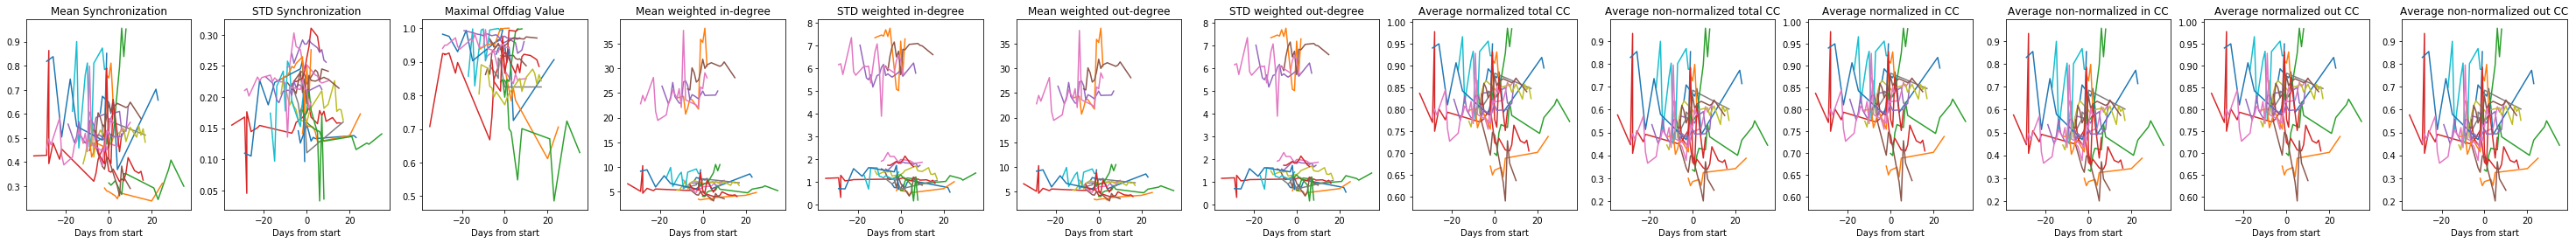

In [24]:
testNames = [
    "Mean Synchronization",
    "STD Synchronization",
    "Maximal Offdiag Value",
    "Mean weighted in-degree",
    "STD weighted in-degree",
    "Mean weighted out-degree",
    "STD weighted out-degree",
    "Average normalized total CC",
    "Average non-normalized total CC",
    "Average normalized in CC",
    "Average non-normalized in CC",
    "Average normalized out CC",
    "Average non-normalized out CC"]
nTest = len(testNames)

fig, ax = plt.subplots(ncols=nTest, figsize=(nTest*4, 4))

for mousename in sorted(dataDB.mice):
    mouseData = dataDB.get_rows('neuro', {'mousename': mousename})

    if mouseData.shape[0] > 0:    
#         dataIdxs = list(mouseData["date"].index)
        
#         testResults = np.zeros((len(dataIdxs), nTest))
        testResults = []
        for idx, row in mouseData.iterrows():
            # Compute cross-correlation absolute value
            dataThis = dataDB.dataNeuronal[idx]
            cAbs = np.abs(corr_3D(dataThis, {'dim_order' : 'rsp'})[0])
            
            # Compute connectivity metrics
            testResults += [np.array([
                *graph_lib.diagonal_dominance(cAbs),
                np.max(graph_lib.offdiag(cAbs)),
                np.mean(graph_lib.degree_in(cAbs)),
                np.std(graph_lib.degree_in(cAbs)),
                np.mean(graph_lib.degree_out(cAbs)),
                np.std(graph_lib.degree_out(cAbs)),
                np.mean(graph_lib.clustering_coefficient(cAbs, kind='tot', normDegree=True)),
                np.mean(graph_lib.clustering_coefficient(cAbs, kind='tot', normDegree=False)),
                np.mean(graph_lib.clustering_coefficient(cAbs, kind='in', normDegree=True)),
                np.mean(graph_lib.clustering_coefficient(cAbs, kind='in', normDegree=False)),
                np.mean(graph_lib.clustering_coefficient(cAbs, kind='out', normDegree=True)),
                np.mean(graph_lib.clustering_coefficient(cAbs, kind='out', normDegree=False))
            ])]
            
        testResults = np.array(testResults)
            
        for iTest in range(nTest):
            ax[iTest].plot(mouseData["deltaDaysCentered"], testResults[:,iTest], label=mousename)

for iTest in range(nTest):
    ax[iTest].set_title(testNames[iTest])
    ax[iTest].set_xlabel("Days from start")
    #ax[iTest].legend()
plt.show()

## 1.2 Clustering of data

1. For each mouse, for each time, compute corr
2. Compute CC vs time (mean/var)
3. Plot for all mice
4. Then split Go/NoGO

mtp_1


IntProgress(value=0, description='mtp_1_iGO', max=9)

IntProgress(value=0, description='mtp_1_iNOGO', max=9)

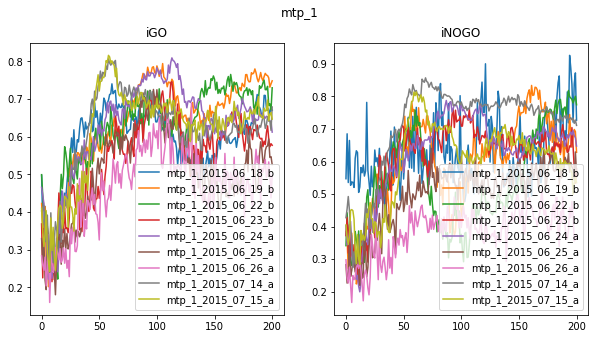

mtp_10


IntProgress(value=0, description='mtp_10_iGO', max=8)

IntProgress(value=0, description='mtp_10_iNOGO', max=8)

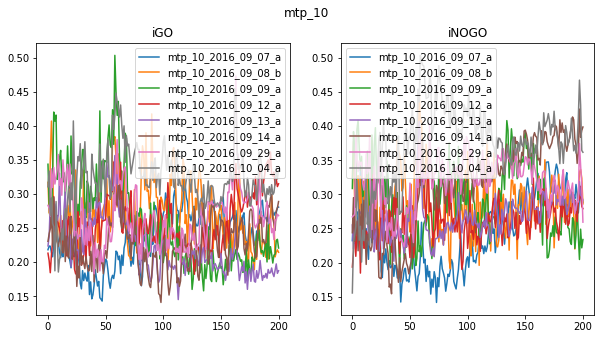

mtp_11


IntProgress(value=0, description='mtp_11_iGO', max=12)

IntProgress(value=0, description='mtp_11_iNOGO', max=12)

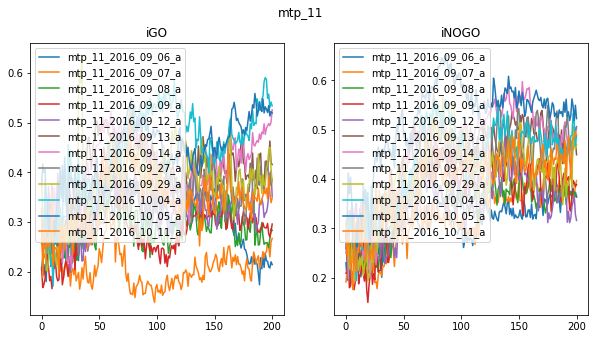

mtp_12


IntProgress(value=0, description='mtp_12_iGO', max=24)

IntProgress(value=0, description='mtp_12_iNOGO', max=24)

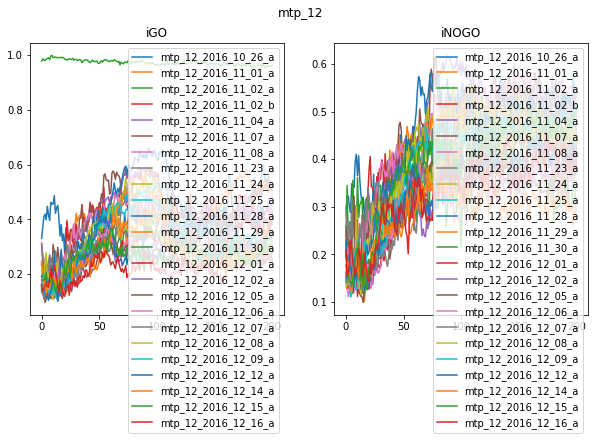

mtp_13


IntProgress(value=0, description='mtp_13_iGO', max=12)

IntProgress(value=0, description='mtp_13_iNOGO', max=12)

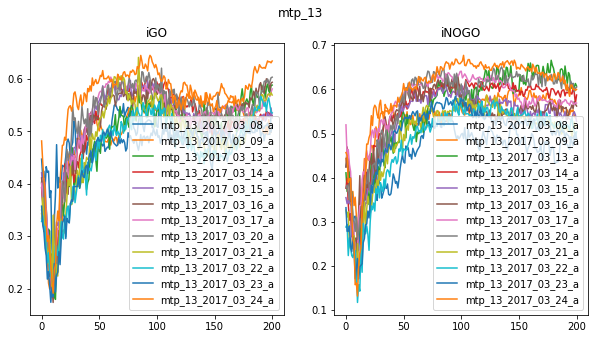

mtp_15


IntProgress(value=0, description='mtp_15_iGO', max=13)

IntProgress(value=0, description='mtp_15_iNOGO', max=13)

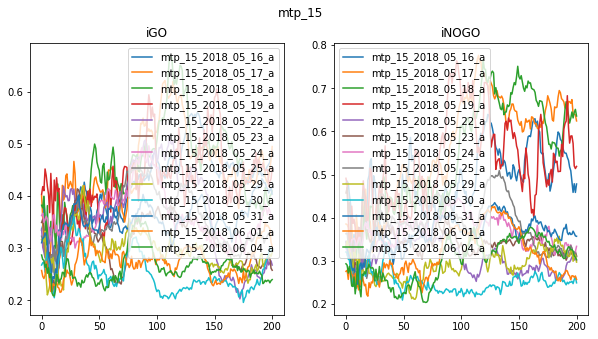

mtp_16


IntProgress(value=0, description='mtp_16_iGO', max=13)

IntProgress(value=0, description='mtp_16_iNOGO', max=13)

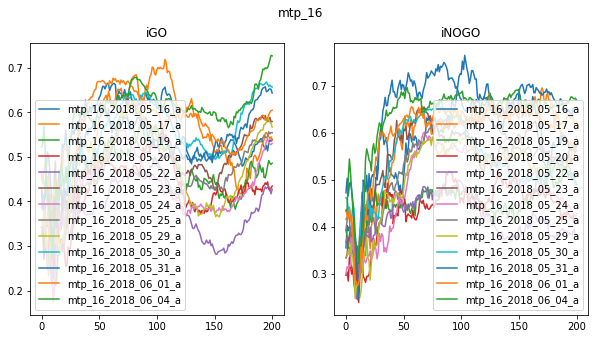

mtp_2


IntProgress(value=0, description='mtp_2_iGO', max=8)

IntProgress(value=0, description='mtp_2_iNOGO', max=8)

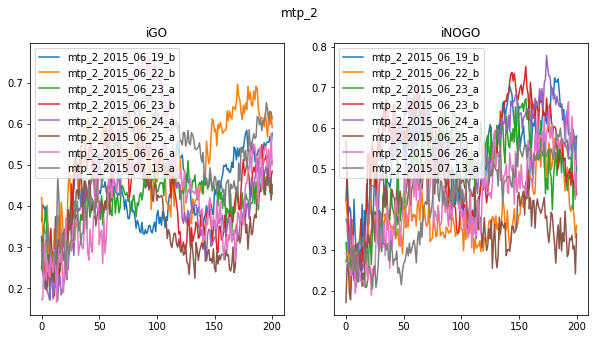

mtp_7


IntProgress(value=0, description='mtp_7_iGO', max=18)

IntProgress(value=0, description='mtp_7_iNOGO', max=18)

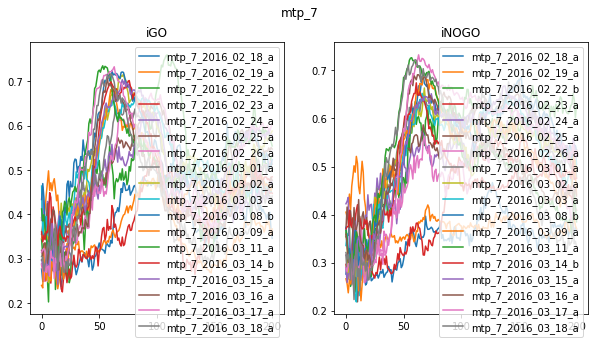

mvg_2


IntProgress(value=0, description='mvg_2_iGO', max=11)

IntProgress(value=0, description='mvg_2_iNOGO', max=11)

KeyboardInterrupt: 

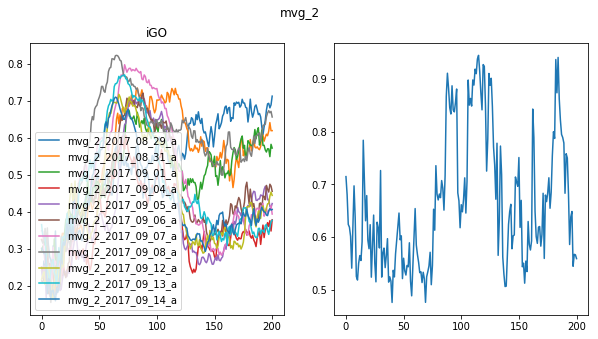

In [43]:
trialKeys = ['iGO', 'iNOGO']
nTrialKeys = len(trialKeys)

for mousename in sorted(dataDB.mice):
    print(mousename)
    
    mouseData = dataDB.get_rows('neuro', {'mousename': mousename})
    if mouseData.shape[0] > 0:
        fig, ax = plt.subplots(ncols=nTrialKeys, figsize=(5*nTrialKeys,5))
        fig.suptitle(mousename)
        
        for iKey, trialKey in enumerate(trialKeys):
            progBar = IntProgress(min=0, max=len(mouseData), description=mousename + '_' + trialKey)
            display(progBar)  # display the bar
            
            for idx, row in mouseData.iterrows():
                dataLabel = row['mousekey']
                trialIdx = dataDB.dataTrials[idx][trialKey]
                dataThis = dataDB.dataNeuronal[idx][trialIdx-1]

#                 print("--", dataLabel, trialKey, len(trialIdx))

                nTrial, nTime, nChannel = dataThis.shape

                ccNoNorm = np.zeros(nTime)
                for iTime in range(nTime):
                    corrAbs = np.abs(corr_2D(dataThis[:, iTime, :].T)[0])
                    ccNoNorm[iTime] = np.mean(graph_lib.clustering_coefficient(corrAbs, normDegree=False))

                ax[iKey].plot(ccNoNorm, label=dataLabel)
                
                progBar.value += 1

            ax[iKey].set_title(trialKey)
            ax[iKey].legend()
    plt.show()